In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from binance.client import Client
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
%matplotlib inline
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import datetime
from datetime import datetime

In [2]:
api_key = '<your api key>'
api_secret = '<your api secret>'
client = Client(api_key, api_secret)
symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_15MINUTE
bars = client.get_historical_klines(symbol, interval, "1 Jan 2017")
df = pd.DataFrame(bars, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
df.set_index('Timestamp', inplace=True)
df.drop(['Open', 'High', 'Low', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'], axis=1, inplace=True)
print(df)

                              Close
Timestamp                          
2017-08-17 04:00:00   4261.48000000
2017-08-17 04:15:00   4261.45000000
2017-08-17 04:30:00   4310.07000000
2017-08-17 04:45:00   4308.83000000
2017-08-17 05:00:00   4304.31000000
...                             ...
2023-04-15 10:45:00  30417.07000000
2023-04-15 11:00:00  30411.65000000
2023-04-15 11:15:00  30405.20000000
2023-04-15 11:30:00  30414.70000000
2023-04-15 11:45:00  30381.94000000

[197899 rows x 1 columns]


In [3]:
df1 = df
df1 = np.array(df1)
df1 = df1.tolist()
len(df1)
price1d = np.array([float(df1[i][0]) for i in range(197210)])
price1d.shape

(197210,)

In [4]:
from sklearn.preprocessing import StandardScaler
price1d = price1d.reshape(197210,1)
scaler = StandardScaler()
scaler.fit(price1d[:145935])

StandardScaler()

In [5]:
StandardScaler(copy=False, with_mean=False, with_std=True)
price1d = scaler.transform(price1d)
df1 = pd.DataFrame(price1d.reshape(39442,5),columns=['First','Second','Third','Fourth', 'Target'])
df1.head()

,First,Second,Third,Fourth,Target
0,-0.735868,-0.735870,-0.732714,-0.732795,-0.733088
1,-0.732070,-0.733928,-0.732374,-0.731421,-0.732653
2,-0.730418,-0.731788,-0.732289,-0.733927,-0.733368
3,-0.730124,-0.729428,-0.729429,-0.729429,-0.729429
4,-0.729474,-0.729474,-0.724509,-0.724023,-0.726878


In [6]:

x_train1d = df1.iloc[:29581,:4]
y_train1d = df1.iloc[:29581,-1]
x_test1d = df1.iloc[29583:39441,:4]
y_test1d = df1.iloc[29583:39441,-1]
x_train1d = np.array(x_train1d)
y_train1d = np.array(y_train1d)
x_test1d = np.array(x_test1d)
y_test1d = np.array(y_test1d)
x_train1d = np.reshape(x_train1d, (x_train1d.shape[0], x_train1d.shape[1], 1))
from tensorflow.signal import fft
x_train1d_fft = fft(x_train1d)
x_test1d_fft = fft(x_test1d)
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(4, 1)))
model.add(LSTM(40, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
print(model.summary())
model.fit(x_train1d, y_train1d, batch_size=10,epochs=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 20)             1760      
                                                                 
 lstm_1 (LSTM)               (None, 40)                9760      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 11,561
Trainable params: 11,561
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2959/2959 [==============================] - 11s 3ms/step - loss: 0.0074
Epoch 2/10
2959/2959 [==============================] - 8s 3ms/step - loss: 7.0413e-04
Epoch 3/10
2959/2959 [==============================] - 8s 3ms/step - loss: 5.9874e-04
Epoch 4/10
2959/2959 [==============================]

309/309 [==============================] - 1s 1ms/step


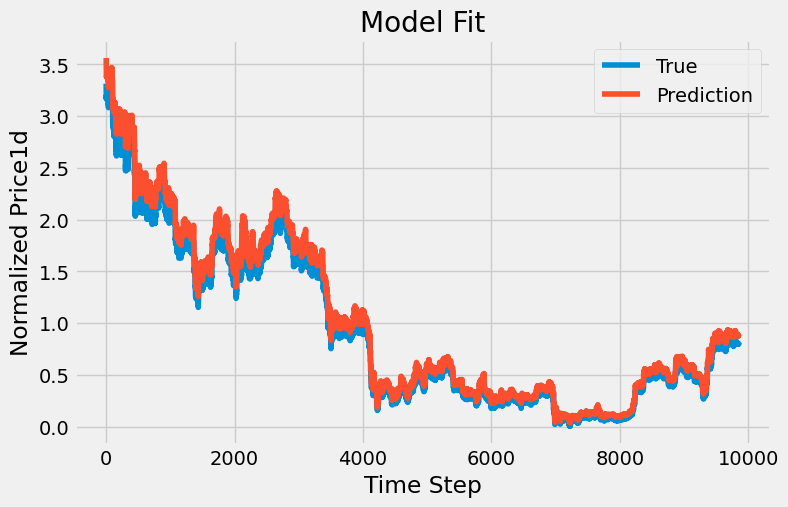

In [7]:
y_pred1d = model.predict(x_test1d)
plt.figure(figsize=[8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Normalized Price1d')
plt.plot(y_test1d, label='True')
plt.plot(y_pred1d, label='Prediction')
plt.legend()

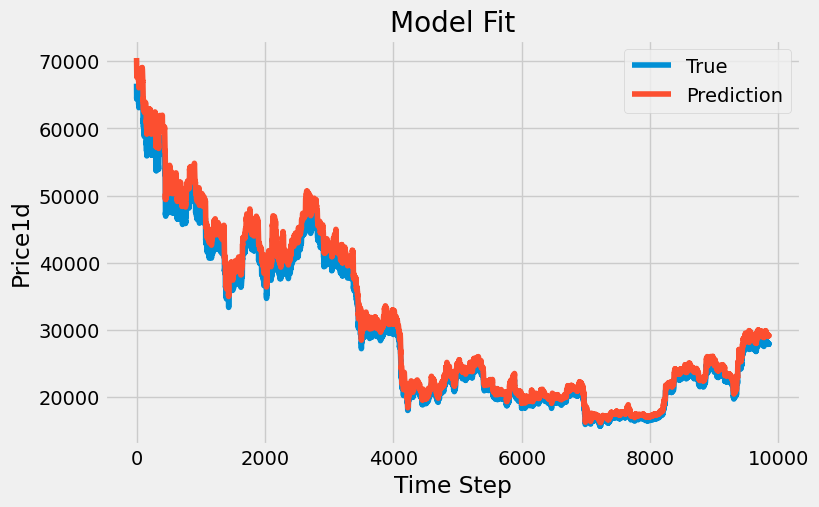

In [8]:
y_pred1d = np.array(y_pred1d.reshape(9858,1))
y_test1d = np.array(y_test1d.reshape(9858,1))
plt.figure(figsize=[8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Price1d')
plt.plot(scaler.inverse_transform(y_test1d), label='True')
plt.plot(scaler.inverse_transform(y_pred1d), label='Prediction')
plt.legend()

In [9]:
api_key = '<your api key>'
api_secret = '<your api secret>'
client = Client(api_key, api_secret)
symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_5MINUTE
bars = client.get_historical_klines(symbol, interval, "1 Jan 2017")
df = pd.DataFrame(bars, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
df.set_index('Timestamp', inplace=True)
df.drop(['Open', 'High', 'Low', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'], axis=1, inplace=True)
print(df)

                              Close
Timestamp                          
2017-08-17 04:00:00   4261.48000000
2017-08-17 04:05:00   4261.48000000
2017-08-17 04:10:00   4261.48000000
2017-08-17 04:15:00   4261.48000000
2017-08-17 04:20:00   4266.29000000
...                             ...
2023-04-15 11:40:00  30414.70000000
2023-04-15 11:45:00  30365.81000000
2023-04-15 11:50:00  30381.94000000
2023-04-15 11:55:00  30385.30000000
2023-04-15 12:00:00  30386.53000000

[593678 rows x 1 columns]


In [10]:
df2 = df
df2 = np.array(df2)
df2 = df2.tolist()
price2d = np.array([float(df2[i][0]) for i in range(591610)])
price2d = price2d.reshape(591610,1)
scaler = StandardScaler()
scaler.fit(price2d[:437791])
StandardScaler(copy=False, with_mean=False, with_std=True)
price2d = scaler.transform(price2d)
df2 = pd.DataFrame(price2d.reshape(118322,5),columns=['First','Second','Third','Fourth', 'Target'])
df2.head()

,First,Second,Third,Fourth,Target
0,-0.735863,-0.735863,-0.735863,-0.735863,-0.735551
1,-0.735865,-0.733582,-0.733339,-0.732710,-0.733882
2,-0.732481,-0.732790,-0.733084,-0.731502,-0.733084
3,-0.732066,-0.732066,-0.732066,-0.732066,-0.733923
4,-0.733923,-0.733556,-0.732369,-0.732369,-0.731398


In [11]:
x_train2d = df2.iloc[:88741,:4]
y_train2d = df2.iloc[:88741,-1]
x_test2d = df2.iloc[88743:118321,:4]
y_test2d = df2.iloc[88743:118321,-1]
x_train2d = np.array(x_train2d)
y_train2d = np.array(y_train2d)
x_test2d = np.array(x_test2d)
y_test2d = np.array(y_test2d)
x_train2d = np.reshape(x_train2d, (x_train2d.shape[0], x_train2d.shape[1], 1))
x_test2d  = np.reshape(x_test2d, (x_test2d.shape[0], x_test2d.shape[1], 1))
from tensorflow.signal import fft
x_train2d_fft = fft(x_train2d)
x_test2d_fft = fft(x_test2d)
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(4, 1)))
model.add(LSTM(40, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
print(model.summary())
model.fit(x_train2d, y_train2d, batch_size=10,epochs=10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4, 20)             1760      
                                                                 
 lstm_3 (LSTM)               (None, 40)                9760      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 11,561
Trainable params: 11,561
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
8875/8875 [==============================] - 27s 3ms/step - loss: 0.0023
Epoch 2/10
8875/8875 [==============================] - 25s 3ms/step - loss: 3.5881e-04
Epoch 3/10
8875/8875 [==============================] - 25s 3ms/step - loss: 2.7145e-04
Epoch 4/10
8875/8875 [===========================

925/925 [==============================] - 2s 1ms/step


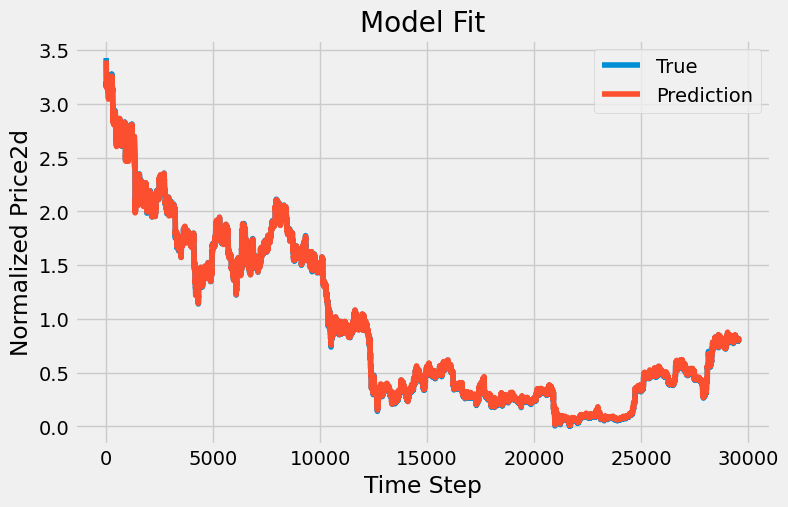

In [12]:
y_pred2d = model.predict(x_test2d)
plt.figure(figsize=[8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Normalized Price2d')
plt.plot(y_test2d, label='True')
plt.plot(y_pred2d, label='Prediction')
plt.legend()

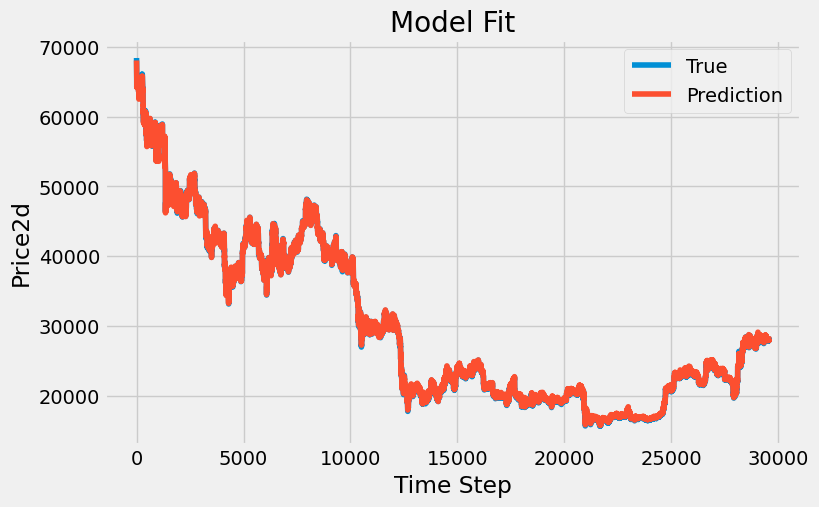

In [13]:
y_pred2d = np.array(y_pred2d.reshape(29578,1))
y_test2d = np.array(y_test2d.reshape(29578,1))
plt.figure(figsize=[8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Price2d')
plt.plot(scaler.inverse_transform(y_test2d), label='True')
plt.plot(scaler.inverse_transform(y_pred2d), label='Prediction')
plt.legend()

In [14]:
api_key = 'paste your keys here'
api_secret = 'paste your keys here'
client = Client(api_key, api_secret)
candles = client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1MINUTE, limit = 1000)
len(candles)

1000

In [15]:
price = np.array([float(candles[i][4]) for i in range(1000)])
openprice = np.array([float(candles[i][1]) for i in range(1000)])
time = np.array([int(candles[i][0]) for i in range(1000)])
t = np.array([datetime.fromtimestamp(time[i]/1000).strftime('%H:%M:%S') for i in range(1000)])
price.shape, openprice.shape

((1000,), (1000,))

In [16]:
price = price.reshape(1000,1)
price.shape

(1000, 1)

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(price[:750])

StandardScaler()

In [18]:
StandardScaler(copy=False, with_mean=False, with_std=True)
price = scaler.transform(price)
df = pd.DataFrame(price.reshape(200,5),columns=['First','Second','Third','Fourth','Target'])
df.head()

,First,Second,Third,Fourth,Target
0,-2.627233,-2.732123,-2.894225,-2.417038,-2.338267
1,-2.416623,-2.234828,-2.224463,-1.930107,-2.019865
2,-2.006806,-2.075627,-1.946069,-2.006806,-1.602792
3,-1.251017,-1.467845,-1.488574,-1.544543,-1.733180
4,-1.938192,-1.832887,-1.808841,-1.824803,-1.515315


In [19]:
x_train = df.iloc[:174,:4]
y_train = df.iloc[:174,-1]
x_test = df.iloc[175:199,:4]
y_test = df.iloc[175:199,-1]
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test  = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_train = fft(x_train)
x_test = fft(x_test)
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(4, 1)))
model.add(LSTM(40, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
print(model.summary())
model.fit(x_train, y_train, batch_size=5,epochs=110)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 4, 20)             1760      
                                                                 
 lstm_5 (LSTM)               (None, 40)                9760      
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 11,561
Trainable params: 11,561
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/110
35/35 [==============================] - 3s 3ms/step - loss: 0.4115
Epoch 2/110
35/35 [==============================] - 0s 3ms/step - loss: 0.1451
Epoch 3/110
35/35 [==============================] - 0s 3ms/step - loss: 0.1379
Epoch 4/110
35/35 [==============================] - 0s 3ms/step - lo

1/1 [==============================] - 1s 553ms/step


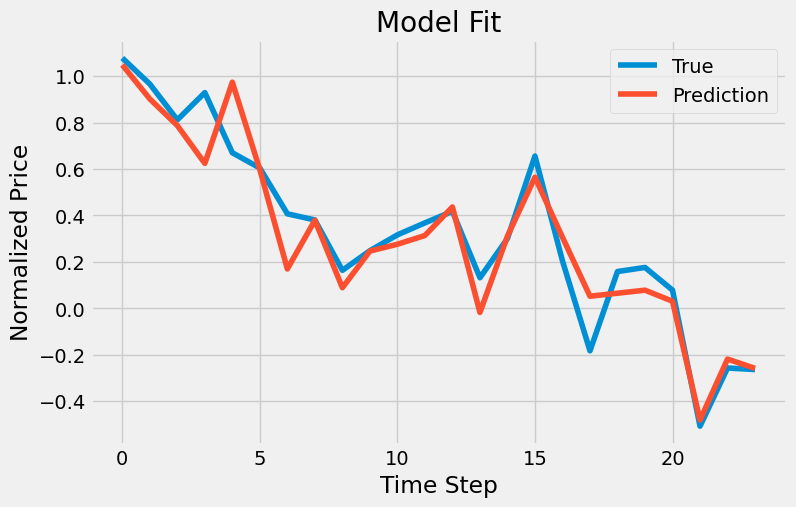

In [20]:
y_pred = model.predict(x_test)
plt.figure(figsize=[8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Normalized Price')
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Prediction')
plt.legend()

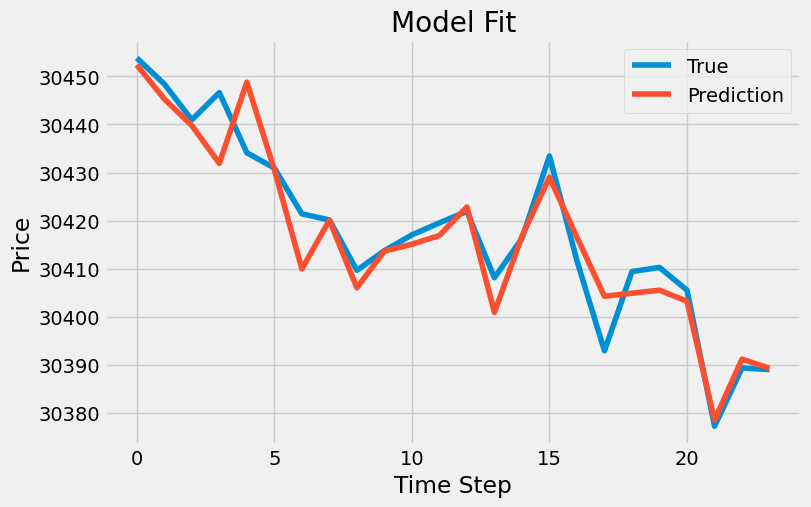

In [21]:
y_pred = np.array(y_pred.reshape(24,1))
y_test = np.array(y_test.reshape(24,1))
plt.figure(figsize=[8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.plot(scaler.inverse_transform(y_test), label='True')
plt.plot(scaler.inverse_transform(y_pred), label='Prediction')
plt.legend()

In [22]:
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(y_pred)))
print('Test Score: %.2f RMSE' % (testScore))
from sklearn.metrics import r2_score
print('RSquared :','{:.2%}'.format(r2_score(y_test,y_pred)))

Test Score: 6.05 RMSE
RSquared : 89.91%


In [23]:
from sklearn.svm import SVR
#75% train , 25% test
trainX = df.iloc[:174,:4]
trainY = df.iloc[:174,-1]
testX = df.iloc[175:199,:4]
testY = df.iloc[175:199,-1]
svr_linear = SVR(kernel='linear',C=1e3, gamma=0.1)
svr_linear.fit(trainX,trainY)
SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
predY = svr_linear.predict(testX)

In [24]:
predY = np.array(predY.reshape(24,1))
testY = np.array(testY.values.reshape(24,1))
testY.shape, predY.shape

((24, 1), (24, 1))

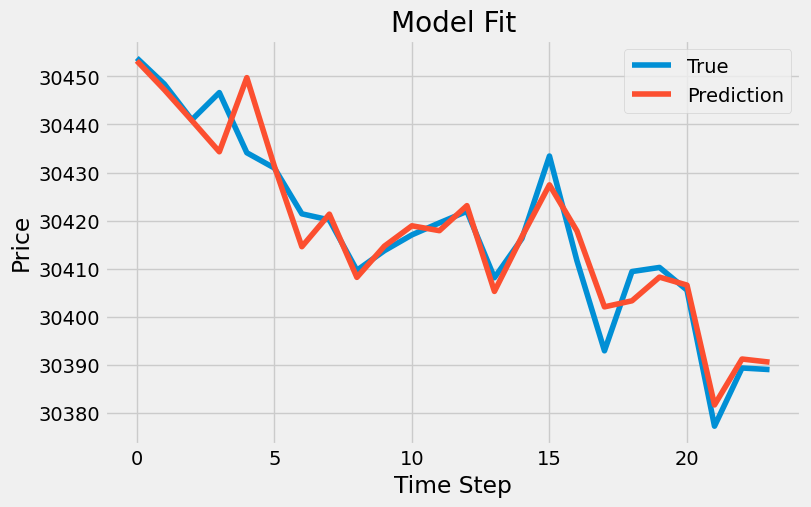

In [25]:
plt.figure(figsize=[8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.plot(scaler.inverse_transform(testY), label='True')
plt.plot(scaler.inverse_transform(predY), label='Prediction')
plt.legend()

In [26]:
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(testY),scaler.inverse_transform(predY)))
print('Test Score: %.2f RMSE' % (testScore))
print('RSquared :','{:.2%}'.format(r2_score(testY,predY)))
param_grid = {"C": [1e-2,1e-1,1e0, 1e1, 1e2, 1e3, 1e4],
              "gamma": np.logspace(-2, 2, 50),
             'epsilon':[0.1,0.2,0.5,0.3]}
from sklearn.model_selection import RandomizedSearchCV
svm_model = SVR(kernel='linear')
grid_search = RandomizedSearchCV(svm_model,param_grid,scoring='r2',n_jobs=-1)
grid_search.fit(trainX,trainY)
print(grid_search.best_estimator_)
SVR(C=10000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=100.0,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svm_model = SVR(C=10000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=100.0,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svm_model.fit(trainX,trainY)
pred = svm_model.predict(testX)

Test Score: 5.36 RMSE
RSquared : 92.09%
SVR(C=10.0, epsilon=0.3, gamma=1.5998587196060574, kernel='linear')


In [27]:
pred = np.array(pred.reshape(24,1))
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(testY),scaler.inverse_transform(pred)))
print('Test Score: %.2f RMSE' % (testScore))
print('RSquared :','{:.2%}'.format(r2_score(testY,pred)))

Test Score: 5.35 RMSE
RSquared : 92.10%


In [28]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV()
ridge.fit(trainX,trainY)
Rpred = ridge.predict(testX)
Rpred = np.array(Rpred.reshape(24,1))
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(testY),scaler.inverse_transform(Rpred)))
print('Test Score :',testScore)
print('RSquared :','{:.2%}'.format(r2_score(testY,Rpred)))

Test Score : 5.761888055480226
RSquared : 90.84%


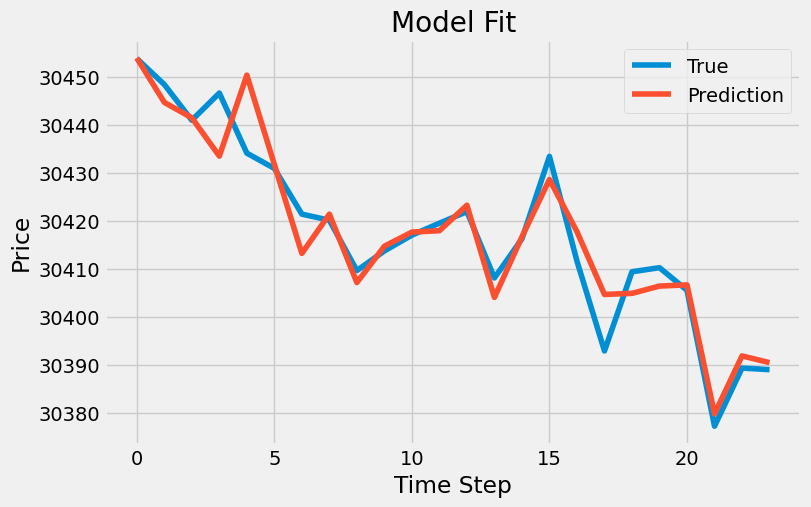

In [29]:
plt.figure(figsize=[8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.plot(scaler.inverse_transform(testY), label='True')
plt.plot(scaler.inverse_transform(Rpred), label='Prediction')
plt.legend()

In [30]:
normal_price = np.array([float(candles[i][4]) for i in range(1000)])
data = pd.DataFrame(normal_price.reshape(200,5),columns=['First','Second','Third','Fourth','Target'])

In [34]:
from torch import nn
x_train_r = data.iloc[:174,:4].to_numpy().astype(float)
y_train_r = data.iloc[:174,-1].to_numpy().astype(float)
x_test_r = data.iloc[175:199,:4].to_numpy().astype(float)
y_test_r = data.iloc[175:199,-1].to_numpy().astype(float)
from tpot import TPOTClassifier
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=15, population_size=25, verbosity=2)
tpot.fit(x_train_r, y_train_r)

                                                                                                                       
Generation 1 - Current best internal CV score: -148.87182940642273
                                                                                                                       
Generation 2 - Current best internal CV score: -144.40505080702653
                                                                                                                       
Generation 3 - Current best internal CV score: -144.40505080702653
                                                                                                                       
Generation 4 - Current best internal CV score: -144.40505080702653
                                                                                                                       
Generation 5 - Current best internal CV score: -144.40505080702653
                                                                 

TPOTRegressor(generations=15, population_size=25, verbosity=2)

In [33]:
x_test_r.shape, tpred.shape

((24, 4), (24,))

In [35]:
tpred = tpot.predict(x_test_r)
testScore = np.sqrt(mean_squared_error(y_test_r,tpred))
print('Test Score: %.2f RMSE' % (testScore))
print('RSquared :','{:.2%}'.format(r2_score(y_test_r,tpred)))

Test Score: 5.66 RMSE
RSquared : 91.16%


In [40]:
check = client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_15MINUTE)
index = [496,495,498,499]
candles = scaler.transform(np.array([float(check[i][4]) for i in index]).reshape(4,-1))
model_feed = candles.reshape(1,4,1)
scaler.inverse_transform(model.predict(model_feed))[0][0]

1/1 [==============================] - 1s 547ms/step


30390.326

In [39]:
from h5py import version
import h5py 
from h5py import version
model.save("BeefedBitcoinCyclical_model.h5") 
from keras.models import load_model 
model = load_model('BeefedBitcoinCyclical_model.h5') 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 4, 20)             1760      
                                                                 
 lstm_5 (LSTM)               (None, 40)                9760      
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 11,561
Trainable params: 11,561
Non-trainable params: 0
_________________________________________________________________
